## HW4_410878049_柯怡瑄
##  深度機器學習在影像辨識與生成的練習作業
### 目的 : 本次的作品是要利用 CNN 模型進行高解析度影像生成的訓練（SRCNN）。藉由低解析度生成高解析度的影像。包含利用原圖進行訓練的與利用殘差訓練的兩種方法比較。

## Step 1 影像預處理
將原始圖片經 bicubic 方法 resize 成想要大小的低解析度影像。bicubic (雙三次差值法)，是二維空間中常用的插值方法，每個目標像素的值是通過對最近的16個採樣點進行加權計算得到的。相較於雙線性插值，雙三次差值法可以保留更好的細節品質，並且邊界感會較不明顯，但所需時間較長。
## Step 2 低解析度影像
SRCNN 中包含了三層捲積網路，目的分別如下

1. Patch extraction and representation
2. Non-linear mapping
3. Reconstruction

## Step 3 訓練並計算 PSNR

峰值訊噪比 (PSNR) 透過 MSE 定義，用在影像資料中是為了觀察原圖和壓縮圖 (或者說是相較的圖) 的差異大小，值越大表示差異越小。

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import time
import srcnn
from srcnn import SRCNN
import torch.optim as optim
import torch.nn as nn
import os
import argparse

import tqdm.notebook as tq
from datasets import get_datasets, get_dataloaders
from utils import (
    psnr, save_model, save_model_state, 
    save_plot, save_validation_results
)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 原圖
大部分的模型設定都和下載檔案差不多，有改變的部分在於　learning rate 改為 0.0001 和增加 epoch　數。

#### 1. 將已經訓練 500 次的 pre-train  pth 檔讀入並再訓練三次。

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '-e', '--epochs', default=3, type=int,
    help='number of epochs to train for'
)
parser.add_argument(
    '-w', '--weights', default=None,
    help='weights/checkpoint path to resume training'
)

args, unknown = parser.parse_known_args()
args = vars(args)
# Learning parameters.
epochs = args['epochs'] # Number of epochs to train the SRCNN model for.
lr = 0.0001 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Constants
TRAIN_LABEL_PATHS = '../input/t91_hr_patches'
TRAN_IMAGE_PATHS = '../input/t91_lr_patches'
VALID_LABEL_PATHS = '../input/test_hr'
VALID_IMAGE_PATHS = '../input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True

# os.makedirs('../outputs/valid_results', exist_ok=True)

# Initialize the model.
print('Computation device: ', device)
model  = srcnn.SRCNN().to(device)
model.load_state_dict(torch.load('../outputs/0603_500epoch_train/0603model_500epoch_train.pth'))

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function. 
criterion = nn.MSELoss()

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")

def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tq.tqdm(enumerate(dataloader), total=len(dataloader)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # Zero grad the optimizer.
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        # Backpropagation.
        loss.backward()
        # Update the parameters.
        optimizer.step()

        # Add loss of each item (total items in a batch = batch size).
        running_loss += loss.item()
        # Calculate batch psnr (once every `batch_size` iterations).
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tq.tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)

            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr


    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, valid_loader, epoch+1)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Computation device:  cuda
Training samples: 22227
Validation samples: 19
Epoch 1 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train PSNR: 29.815
Val PSNR: 29.619
Epoch 2 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train PSNR: 29.820
Val PSNR: 29.623
Epoch 3 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train PSNR: 29.825
Val PSNR: 29.602
Finished training in: 1.893 minutes


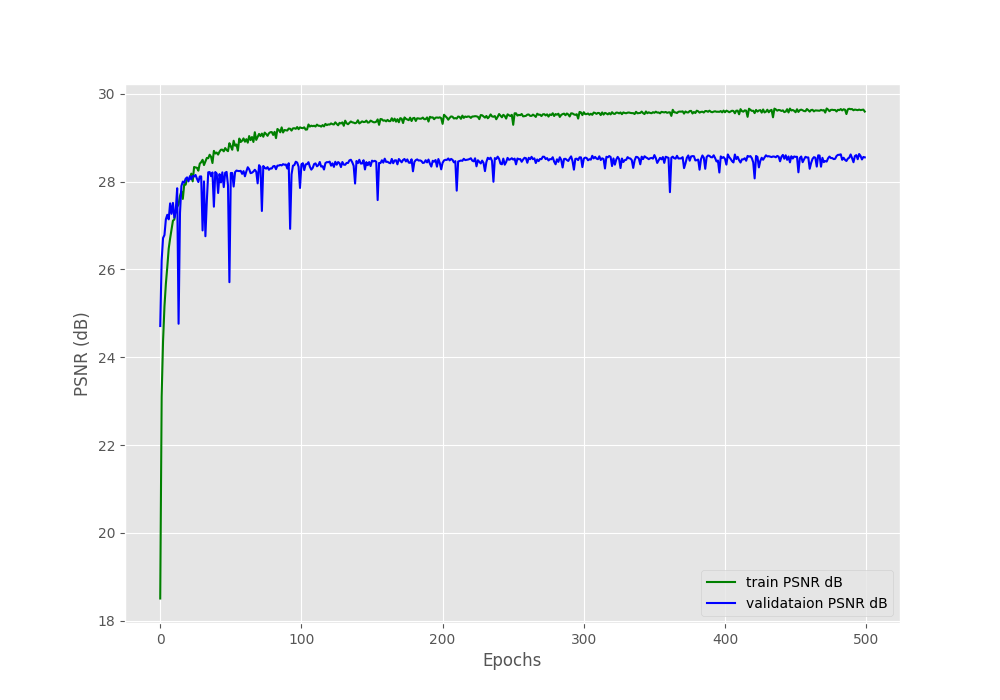

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = r"D:\Colab Notebooks\outputs\0603_500epoch_train\psnr.png", width='600')


兩個 psnr 都會逐漸上升，且 PSNR 會逐漸接近，說明訓練的過程中有成功學習到特徵。

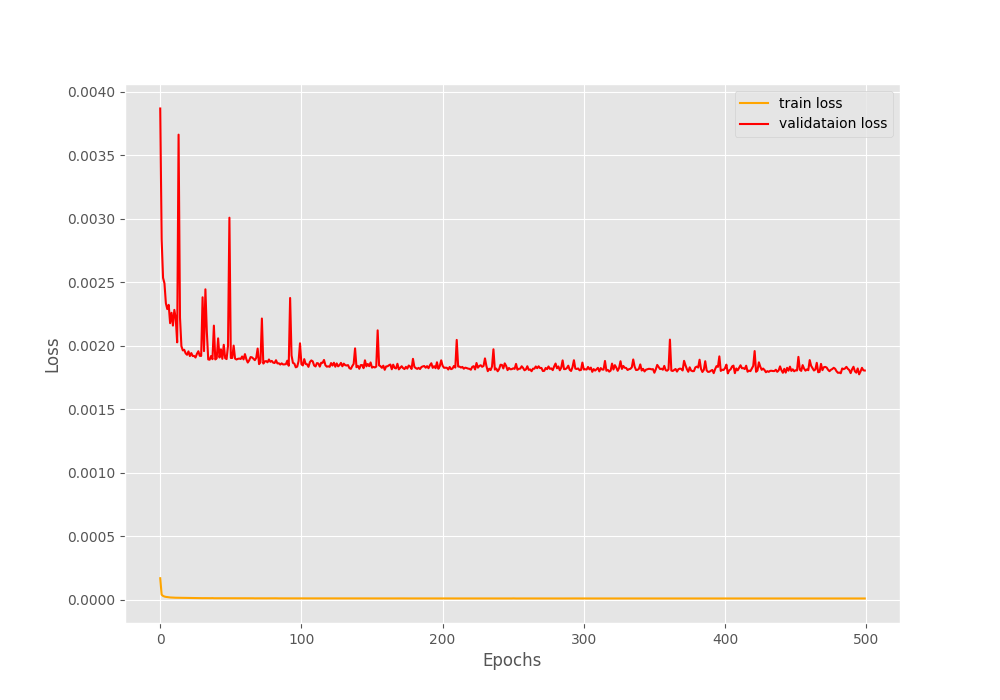

In [4]:
Image(filename = r"D:\Colab Notebooks\outputs\0603_500epoch_train\loss.png", width='600')

首先觀察將下載的訓練方法訓練至 500 次，可以看出 train 和 valid 的 loss 都會逐漸下降，且 train 的 loss 在剛開始便較低。

#### 2. 展示 SET 5、SET 14，的 Test PSNR 

In [5]:
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from srcnn import SRCNN
from PIL import Image
from utils import psnr
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tq.tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]
        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)

        image /= 255.
        label /= 255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_datasets(
    image_paths
):
    dataset_test = SRCNNDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test, 
        batch_size=1,
        shuffle=False
    )
    return test_loader


if __name__ == '__main__':
    # Load the model.
    model = SRCNN().to(device)
    model.load_state_dict(torch.load('../outputs/0603_500epoch_train/0603model_500epoch_train.pth'))

    data_paths = [
        ['../input/Set5/original', 'Set5'],
        ['../input/Set14/original', 'Set14']
    ]

    for data_path in data_paths:
        dataset_test = get_datasets(data_path[0])
        test_loader = get_dataloaders(dataset_test)
        print('\n')

        _, test_psnr = validate(model, test_loader, device)

        print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Test PSNR on Set5: 32.374




  0%|          | 0/14 [00:00<?, ?it/s]

Test PSNR on Set14: 28.551


<!-- ![psnr.png](attachment:psnr.png) -->

## 3 將影像輸入已經訓練好的 CNN 模型中並輸出清晰的影像。
以呈現三張圖片的方法，來顯示本次作品的主要的流程。首先利用插值方法去放大圖片，但因為放大後的圖像清晰程度不盡理想，所以再將放大後的低解析度(low resolution)圖片經過訓練過後的 SRCNN 模型，使圖片提升至高解析度(high resolution)圖。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


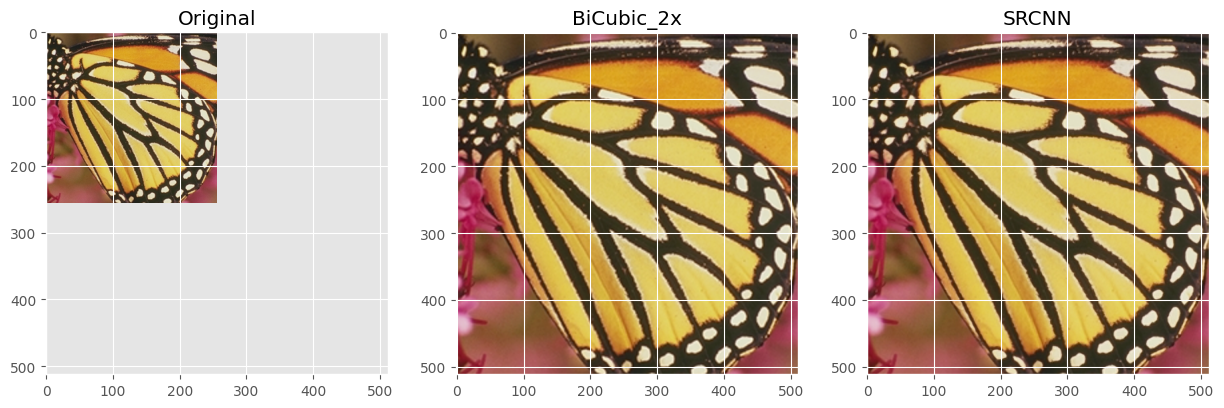

In [6]:
scale = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRCNN().to(device)
model.load_state_dict(torch.load('../outputs/0603_500epoch_train/0603model_500epoch_train.pth'))
model.eval()

orig = Image.open("../input/test_hr/butterfly.png").convert('RGB')
w, h = orig.size[:]
orig = orig.resize([w, h], Image.BICUBIC)
image = orig.resize((w*scale, h*scale), Image.BICUBIC)
orig = np.array(orig, dtype=np.float32)
orig /= 255
image = np.array(image, dtype=np.float32)
image /= 255

image = image.transpose([2, 0, 1])
image = torch.tensor(image, dtype=torch.float).to(device)
out = model(image)

image = image.cpu().detach().numpy()
out = out.cpu().detach().numpy()

image = image.transpose([1, 2, 0])
out = out.transpose([1, 2, 0])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(orig)
ax[0].set_title("Original")
ax[0].set_xlim(0, w*scale)
ax[0].set_ylim(h*scale, 0)
ax[1].imshow(image)
ax[1].set_title(f"BiCubic_{scale}x")
ax[2].imshow(out)
ax[2].set_title("SRCNN")

plt.show()

可以看到經過 SRCNN 的圖的邊界比較平緩，這樣從視覺上來看就會覺得變清晰。

接著看 PSNR 主要的的概念，也就是說比較兩張圖的相似程度。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2xbicubic psnr:29.394
SRCNN psnr:30.108


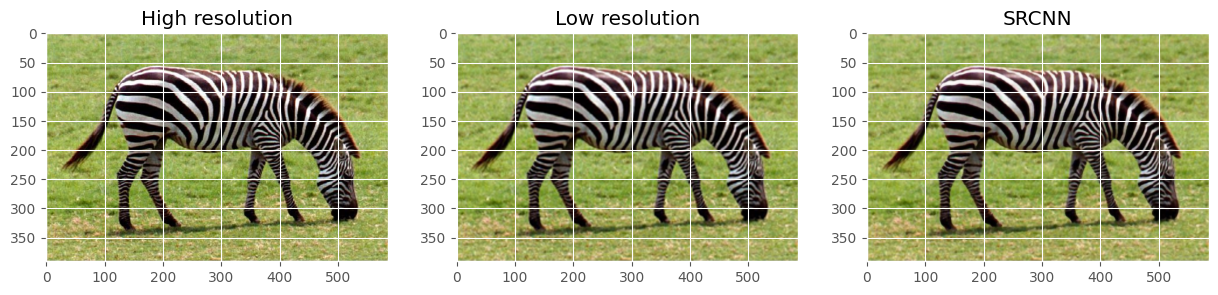

In [7]:
from PIL import Image
from utils import psnr
scale = 2


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRCNN().to(device)
model.load_state_dict(torch.load('../outputs/0603_500epoch_train/0603model_500epoch_train.pth'))
model.eval()

orig = Image.open("../input/test_hr/zebra.png").convert('RGB')
w, h = orig.size[:]
image = orig.resize([w//scale, h//scale], Image.BICUBIC)
image = image.resize((w, h), Image.BICUBIC)
orig = np.array(orig, dtype=np.float32)
orig /= 255
image = np.array(image, dtype=np.float32)
image /= 255

image = image.transpose([2, 0, 1])
image = torch.tensor(image, dtype=torch.float).to(device)
out = model(image)

print('2xbicubic psnr:{:.3f}'.format(psnr(torch.tensor(orig.transpose([2,0,1]), dtype=torch.float).to(device), image)))
print('SRCNN psnr:{:.3f}'.format(psnr(torch.tensor(orig.transpose([2,0,1]), dtype=torch.float).to(device), out)))

image = image.cpu().detach().numpy()
out = out.cpu().detach().numpy()

image = image.transpose([1, 2, 0])
out = out.transpose([1, 2, 0])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(orig)
ax[0].set_title("High resolution")
ax[1].imshow(image)
ax[1].set_title("Low resolution")
ax[2].imshow(out)
ax[2].set_title("SRCNN")

plt.show()


從上方結果可看到，低解度的影像經過 SRCNN 後的 PSNR 會提高，故確實有因為 SRCNN  而提升了清晰程度。

### 用殘差訓練模型
殘差訓練過程
- 將原先切出訓練用的高解析度小圖和低解度小圖互減，將此稱作殘差圖。
- 將殘差圖進行訓練，希望得到可以將低解析度影像放入，算出模擬殘差的 SRCNN 模型。
- 將從 SRCNN 得到的模擬殘差和原先的低解析度照片相加。
- 與原高解析度照片比較並算出 PSNR。

#### 1. 將已經訓練 500 次的 pre-train  pth 檔讀入並再訓練三次。


In [8]:
from datasets import get_datasets, get_dataloaders
parser = argparse.ArgumentParser()
parser.add_argument(
    '-e', '--epochs', default=3, type=int,
    help='number of epochs to train for'
)
parser.add_argument(
    '-w', '--weights', default=None,
    help='weights/checkpoint path to resume training'
)

args, unknown = parser.parse_known_args()
args = vars(args)
# Learning parameters.
epochs = args['epochs'] # Number of epochs to train the SRCNN model for.
lr = 0.0001 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Constants
TRAIN_LABEL_PATHS = '../input/t91_er_patches_no100'
TRAN_IMAGE_PATHS = '../input/t91_lr_patches'
VALID_LABEL_PATHS = '../input/test_hr'
VALID_IMAGE_PATHS = '../input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True

# os.makedirs('../outputs/valid_results', exist_ok=True)

# Initialize the model.
print('Computation device: ', device)
model  = srcnn.SRCNN().to(device)
model.load_state_dict(torch.load('../outputs/0611_1000epoch_res_no100/model.pth'))

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function. 
criterion = nn.MSELoss()

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")

def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tq.tqdm(enumerate(dataloader), total=len(dataloader)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # Zero grad the optimizer.
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(torch.add(outputs,image_data), torch.add(label,image_data))

        # Backpropagation.
        loss.backward()
        # Update the parameters.
        optimizer.step()

        # Add loss of each item (total items in a batch = batch size).
        running_loss += loss.item()
        # img_loss.append(loss.item())
        # Calculate batch psnr (once every `batch_size` iterations).
        batch_psnr =  psnr(torch.add(label,image_data), torch.add(outputs,image_data))
        running_psnr += batch_psnr
        # img_psnr.append(batch_psnr)

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tq.tqdm(enumerate(dataloader), total=len(dataloader)):

            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(torch.add(outputs, image_data), label)

            # Add loss of each item (total items in a batch = batch size).
            running_loss += loss.item()
            # img_loss.append(loss.item())
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr =  psnr(label, torch.add(outputs, image_data))
            running_psnr += batch_psnr
            # img_psnr.append(batch_psnr)

            # For saving the batch samples for the validation results
            # every 500 epochs.
            if SAVE_VALIDATION_RESULTS and (epoch % 500) == 0:
                save_validation_results(outputs, epoch, bi)


    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, valid_loader, epoch+1)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Computation device:  cuda
Training samples: 22227
Validation samples: 19
Epoch 1 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train PSNR: 33.844
Val PSNR: 29.210
Epoch 2 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train PSNR: 33.848
Val PSNR: 29.186
Epoch 3 of 3


  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train PSNR: 33.848
Val PSNR: 29.182
Finished training in: 1.185 minutes


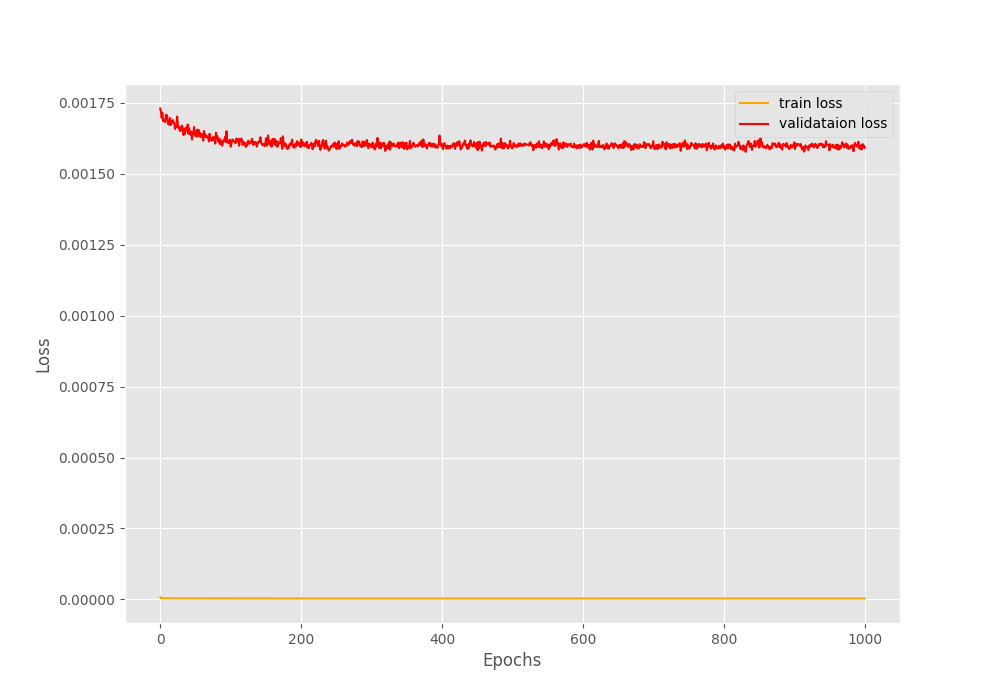

In [9]:
from IPython.display import Image
Image(filename = r"D:\Colab Notebooks\outputs\0611_1000epoch_res_no100\loss.png", width='600')

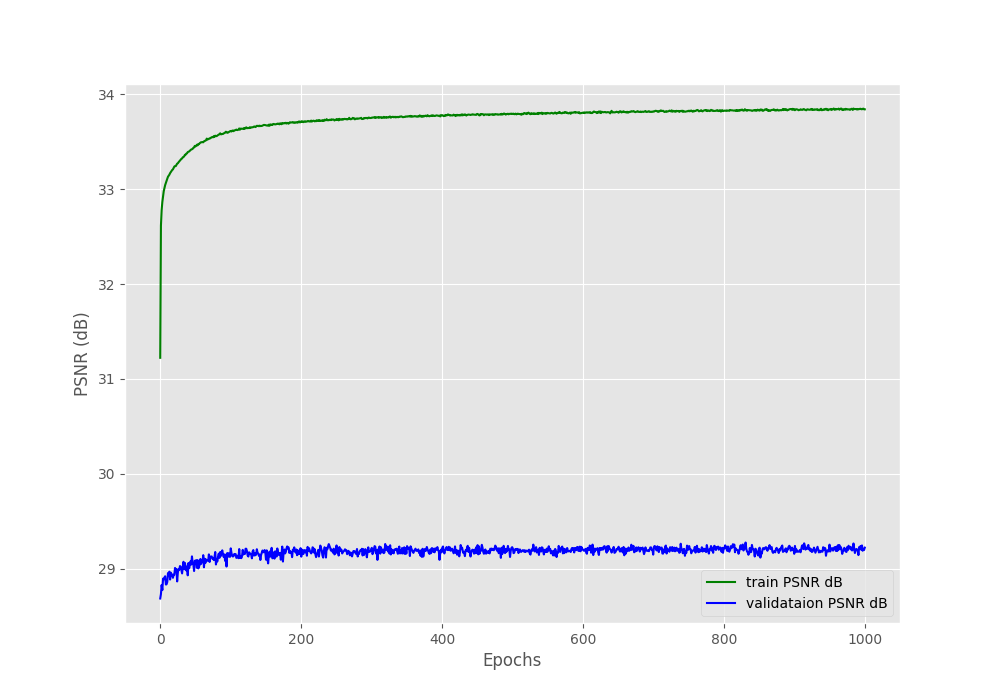

In [10]:
Image(filename = r"D:\Colab Notebooks\outputs\0611_1000epoch_res_no100\psnr.png", width='600')

將這裡的結果和上方單純與用模糊圖的結果比較可以發現，使用殘差圖的 Train PSNR 比較高，並且 Valid PSNR 不會像第一部分的結果般上升至與 Train PSNR 相當的高度，推測是因為是學習了殘差的部分，所以在產出殘差圖的過程中，先去除了一些會混淆學習的部分，所以 Train PSNR 可以較高，但也因為殘差相對而言比較有針對性，故在　Valid PSNR 比較無法因為 epoch 增加而上升。

#### 2. 展示 SET 5、SET 14，的 Test PSNR 

In [11]:
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from srcnn import SRCNN
from PIL import Image
from utils import psnr
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tq.tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(torch.add(label,image_data), torch.add(outputs,image_data))
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]
        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)
        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)
        res=(label-image)

        image /= 255.
        label /= 255.
        res/=255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])
        res = res.transpose([2, 0, 1])

        return (
            # torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float),
            torch.tensor(res, dtype=torch.float)
        )

# Prepare the datasets.
def get_datasets(
    image_paths
):
    dataset_test = SRCNNDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test, 
        batch_size=1,
        shuffle=False
    )
    return test_loader


if __name__ == '__main__':
    # Load the model.
    model = SRCNN().to(device)
    model.load_state_dict(torch.load('../outputs/0611_1000epoch_res_no100/model.pth'))

    data_paths = [
        ['../input/Set5/original', 'Set5'],
        ['../input/Set14/original', 'Set14']
    ]

    for data_path in data_paths:
        dataset_test = get_datasets(data_path[0])
        test_loader = get_dataloaders(dataset_test)
        print('\n')

        _, test_psnr = validate(model, test_loader, device)

        print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Test PSNR on Set5: 31.005




  0%|          | 0/14 [00:00<?, ?it/s]

Test PSNR on Set14: 27.382


## 3 將影像輸入已經訓練好的 CNN 模型中並輸出清晰的影像。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2xbicubic psnr:26.116
SRCNN psnr:26.717


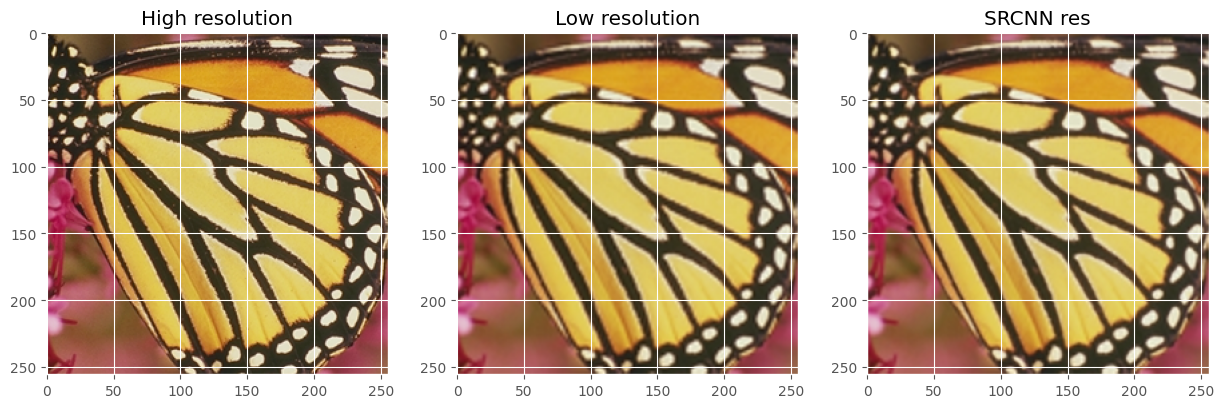

In [12]:
from PIL import Image
scale = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRCNN().to(device)
model.load_state_dict(torch.load('../outputs/0611_1000epoch_res_no100/model.pth'))
model.eval()

orig = Image.open("../input/test_hr/butterfly.png").convert('RGB')
w, h = orig.size[:]
image = orig.resize([w//scale, h//scale], Image.BICUBIC)
image = image.resize((w, h), Image.BICUBIC)
orig = np.array(orig, dtype=np.float32)
orig /= 255
image = np.array(image, dtype=np.float32)
image /= 255

image = image.transpose([2, 0, 1])
image = torch.tensor(image, dtype=torch.float).to(device)
out = model(image)
out=torch.add(image, out)

print('2xbicubic psnr:{:.3f}'.format(psnr(torch.tensor(orig.transpose([2,0,1]), dtype=torch.float).to(device), image)))
print('SRCNN psnr:{:.3f}'.format(psnr(torch.tensor(orig.transpose([2,0,1]), dtype=torch.float).to(device), out)))

image = image.cpu().detach().numpy()
out = out.cpu().detach().numpy()

image = image.transpose([1, 2, 0])
out = out.transpose([1, 2, 0])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(orig)
ax[0].set_title("High resolution")
ax[1].imshow(image)
ax[1].set_title("Low resolution")
ax[2].imshow(out)
ax[2].set_title("SRCNN res")

plt.show()

從計算結果得出，其實 2xBicubic 的影像和將經過 SRCNN 的殘差加上低解析度影像的圖相比 PSNR　並沒有相差太多，故光看中間與右圖的比較，比較難從肉眼區分差異。所以目前的模型設定可能還需要更多的調整和時間才能達到和論文相同的成果，調整的部分可以包含訓練層數、訓練切小圖的大小等。